In [24]:
import datetime as dt
import pandas as pd
import alphalens as al
import numpy as np
import alphalens as al
import cvxpy
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,8)

mod_path = '/Users/richard.wuebker/Projects/price_data_utils'
if mod_path not in sys.path:
    sys.path.append(mod_path)
    
from data_loader import DataLoader
from mp_historical_prices import HistoricalPrices

In [2]:
dl = DataLoader(prices_dir='../../price_data_utils/prices', info_dir='../../price_data_utils/info', 
                analysis_date_str='2019-07-31', cached_dir='../../price_data_utils/cached')
dl.load_data()

Prediction Date: 2019-08-02


In [3]:
data = dl.data
data.head()

,mkt_cap,beta,book_value,sector,eps,month_ago,year_ago,prev_date,analysis_date,trade_date,pred_date,volume
ticker,,,,,,,,,,,,
CSCO,237152452608,1.028849,36804000000,Technology,2.882000,54.396709,42.582268,56.470001,55.400002,55.389999,53.250000,17441200.0
SITC,2572780544,0.870377,1499137000,Real Estate,1.043000,13.070000,NaN,14.130000,14.250000,14.100000,14.060000,1716149.0
UAL,23613609984,1.278593,10320000000,Industrials,9.838000,88.449997,81.209999,93.930000,91.910004,90.489998,89.430000,2125300.0
TROW,26710714368,1.029243,6579100000,Financial Services,7.945000,109.050003,113.295105,115.360001,113.389999,110.470001,110.050003,1951700.0
ISRG,59875086336,1.289684,7265300000,Healthcare,10.128999,529.309998,520.359985,531.640015,519.510010,523.950012,513.599976,593300.0


In [7]:
hp = HistoricalPrices(prices_dir='../../price_data_utils/prices', 
                      cached_dir='../../price_data_utils/cached',
                      date_str='2019-08-02')
hp.get_prices()
prices = hp.prices

# look for duplicates
p = prices.reset_index()
p.loc[p.duplicated(subset=['Date', 'ticker'], keep='first')]

,index,Date,High,Low,Open,Close,Volume,Adj Close,ticker


In [8]:
prices.head()

,Date,High,Low,Open,Close,Volume,Adj Close,ticker
0,2017-05-12,21.299999,20.270000,21.250000,21.10,10933700.0,21.10,GDI
1,2017-05-15,22.299999,21.010000,21.010000,22.02,3487300.0,22.02,GDI
2,2017-05-16,22.410000,22.049999,22.190001,22.10,1289300.0,22.10,GDI
3,2017-05-17,22.510000,21.670000,22.150000,22.10,1583700.0,22.10,GDI
4,2017-05-18,23.629999,21.980000,22.190001,22.50,4075200.0,22.50,GDI


In [15]:
def transform_prices(df, end_date_str):
    prices_temp = df.pivot(index='Date', columns='ticker', values='Adj Close')
    end_date = dt.datetime.strptime(end_date_str, '%Y-%m-%d')
    start_date = end_date - pd.DateOffset(years=2)
    prices_temp.index = pd.to_datetime(prices_temp.index)
    prices = prices_temp.loc[start_date:end_date]
    return prices.dropna(axis=1)
p = transform_prices(prices, '2018-12-31')
returns = p.pct_change().drop(p.index[0])
print(returns.shape)
returns.head()

(501, 920)


ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACC,...,YUMC,Z,ZAYO,ZBH,ZBRA,ZEN,ZG,ZION,ZNGA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,0.013121,0.049601,0.008639,0.008206,-0.001119,0.014100,0.024815,0.030082,0.007939,0.027254,...,0.014482,-0.003493,-0.032499,0.009194,0.009043,0.004519,-0.002140,0.014358,0.015094,0.009703
2017-01-05,-0.011889,0.012888,-0.017345,-0.000698,0.005085,0.007584,-0.011576,-0.008035,0.008638,0.004987,...,0.013899,-0.018064,-0.063790,0.006425,-0.026198,0.004948,-0.013137,-0.016210,-0.014870,-0.003326
2017-01-06,0.031156,0.000979,0.006973,-0.013090,0.011148,0.000314,0.013384,0.005313,0.027204,0.004764,...,-0.030752,0.007688,0.012179,0.000095,0.014277,0.005819,0.008965,0.006498,0.026415,0.003152
2017-01-09,0.003126,-0.039113,0.018827,-0.000589,0.009159,0.006584,0.008019,0.014642,-0.000981,-0.010865,...,-0.004205,0.006812,0.007154,0.019436,0.000116,0.032043,0.002154,-0.010837,-0.022059,-0.002772
2017-01-10,-0.000831,0.050882,0.029737,0.002300,0.001008,-0.002180,-0.007604,-0.041585,0.013500,-0.010186,...,0.004991,-0.008119,0.015822,0.062336,-0.006165,-0.011212,-0.003493,0.015385,-0.022556,-0.000371


In [16]:
p.head()

ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACC,...,YUMC,Z,ZAYO,ZBH,ZBRA,ZEN,ZG,ZION,ZNGA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,45.458351,28.83,45.210602,169.822006,111.709831,55.652992,79.012138,112.360001,37.014076,43.978065,...,25.735418,37.220001,33.540001,102.037155,86.250000,22.129999,37.380001,41.394863,2.65,52.623463
2017-01-04,46.054810,30.26,45.601189,171.215622,111.584778,56.437721,80.972862,115.739998,37.307915,45.176643,...,26.108110,37.090000,32.450001,102.975266,87.029999,22.230000,37.299999,41.989223,2.69,53.134083
2017-01-05,45.507244,30.65,44.810249,171.096146,112.152229,56.865753,80.035553,114.809998,37.630192,45.401947,...,26.470995,36.419998,30.379999,103.636887,84.750000,22.340000,36.810001,41.308586,2.65,52.957333
2017-01-06,46.925068,30.68,45.122715,168.856430,113.402542,56.883591,81.106766,115.419998,38.653877,45.618229,...,25.656956,36.700001,30.750000,103.646767,85.959999,22.469999,37.139999,41.577003,2.72,53.124260
2017-01-09,47.071735,29.48,45.972256,168.756897,114.441246,57.258114,81.757156,117.110001,38.615971,45.122574,...,25.549070,36.950001,30.969999,105.661240,85.970001,23.190001,37.220001,41.126446,2.66,52.976974


In [18]:
def create_momentum_factor(prices, data):

    # demean by sector
    sector_data = data['sector']
    index_ = sector_data.index.intersection(prices.columns)
    sector_data = sector_data.loc[index_]
    prices = prices.loc[:, index_].copy() # to use only the stocks that are in sector_data
    df = prices.pct_change(252).dropna()
    sectors = sector_data.unique()
    
    # demean by sector
    for sector in sectors:
        col_filter = sector_data[sector_data==sector].index
        means = df.loc[:, col_filter].mean(axis=1)
        df.loc[:, col_filter] = df.loc[:, col_filter].subtract(means, axis=0)
        
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [20]:
momenum = create_momentum_factor(p, data)
print(momentum.shape)
momentum.head()

(250, 920)


ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACC,...,YUMC,Z,ZAYO,ZBH,ZBRA,ZEN,ZG,ZION,ZNGA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03,0.504513,0.890392,0.140202,-0.371174,0.506669,0.659944,0.162844,0.742791,0.543840,-0.141668,...,0.613670,0.154487,0.084377,0.208942,0.226319,0.564392,0.143125,0.184541,0.516981,0.355103
2018-01-04,0.473888,0.807667,0.137563,-0.353279,0.515364,0.627529,0.132162,0.721531,0.529081,-0.179365,...,0.600426,0.135886,0.118644,0.196203,0.239343,0.567701,0.126273,0.172616,0.446097,0.350085
2018-01-05,0.515471,0.764763,0.157202,-0.345947,0.524862,0.643397,0.159286,0.762216,0.520367,-0.182406,...,0.587771,0.169962,0.186636,0.200381,0.292507,0.565354,0.150231,0.192406,0.467925,0.370092
2018-01-08,0.472836,0.792699,0.137839,-0.341939,0.502449,0.616559,0.162937,0.800381,0.475837,-0.171297,...,0.635465,0.165123,0.181138,0.202553,0.286994,0.567423,0.147550,0.178886,0.437500,0.382170
2018-01-09,0.504298,0.838535,0.115741,-0.346871,0.488641,0.618092,0.161067,0.791136,0.479798,-0.175891,...,0.665845,0.141272,0.172425,0.160654,0.326277,0.529539,0.127351,0.219818,0.458647,0.402255


In [21]:
def create_smoothed_factor(factor, window=5):
    df = factor.rolling(window).mean().dropna()
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [23]:
smoothed_momentum = create_smoothed_factor(momentum, 5)
print(smoothed_momentum.shape)
smoothed_momentum.head()

(246, 920)


ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACC,...,YUMC,Z,ZAYO,ZBH,ZBRA,ZEN,ZG,ZION,ZNGA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-09,1.179789,1.574934,-0.438422,-1.691596,1.224949,1.446982,-0.310471,1.548591,1.228712,-1.563644,...,1.424403,-0.336814,-0.370683,-0.050804,0.374447,1.334084,-0.423369,-0.077147,1.089470,0.780881
2018-01-10,1.179789,1.578697,-0.472292,-1.691596,1.217422,1.435693,-0.310471,1.563644,1.183553,-1.571171,...,1.439456,-0.329287,-0.265311,-0.235205,0.476055,1.319031,-0.445949,-0.043278,1.081944,0.792171
2018-01-11,1.157210,1.578697,-0.453476,-1.691596,1.191079,1.446982,-0.220152,1.582461,1.134630,-1.578697,...,1.462035,-0.235205,-0.227679,-0.438422,0.592717,1.303978,-0.355630,-0.013171,1.112050,0.803461
2018-01-12,1.130867,1.578697,-0.393263,-1.691596,1.172263,1.450746,-0.186283,1.593750,1.096997,-1.578697,...,1.492142,-0.197572,-0.276601,-0.611534,0.750775,1.285161,-0.333051,0.020698,1.115813,0.822277
2018-01-16,1.134630,1.559881,-0.272838,-1.691596,1.194842,1.477089,-0.144886,1.608804,1.081944,-1.567407,...,1.518485,-0.178756,-0.359394,-0.728195,0.878727,1.243765,-0.317997,0.058331,1.127103,0.867437


In [29]:
f = momentum.loc[smoothed_momentum.index,:].stack()
print(f.shape)
sf = smoothed_momentum.stack()
print(sf.shape)
adj_p = p.loc[smoothed_momentum.index,:].copy()
print(adj_p.shape)

(226320,)
(226320,)
(246, 920)


In [30]:
factor_data = {}
factor_data['factor'] = al.utils.get_clean_factor_and_forward_returns(f, adj_p, periods=[1])
factor_data['smoothed_factor'] = al.utils.get_clean_factor_and_forward_returns(sf, adj_p, periods=[1])

Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [32]:
factor_data['factor'].head()

1D    factor  factor_quantile
date       asset                                     
2018-01-09 A     -0.013655  0.504298                5
           AA     0.036347  0.838535                5
           AAL    0.032642  0.115741                2
           AAP    0.000905 -0.346871                1
           AAPL  -0.000230  0.488641                5

In [34]:
factor_return_list = []
for key, val in factor_data.items():
    factor_return = al.performance.factor_returns(val)
    factor_return.columns = [key]
    factor_return_list.append(factor_return)

In [35]:
unsmoothed_factor_return = factor_return_list[0]
smoothed_factor_return = factor_return_list[1]

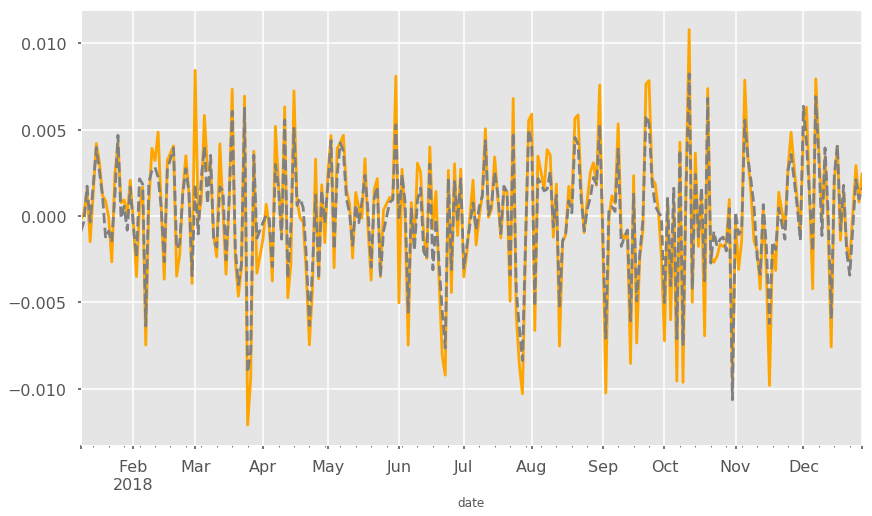

In [38]:
unsmoothed_factor_return['factor'].plot(color='orange')
smoothed_factor_return['smoothed_factor'].plot(color='gray',style='--')